TP: Artfical neural networks
## Student: César Almecija
# ===========================================================

The objective of this practical session is to implement from scratch an artificial neuron network architecture using the numpy library, then to train this neuron network in order to learn the function (non-linear):

$$
f^*(x_1, x_2) = x_1^2 + x_2^2
$$


from training data:

$$
\{(x_n, y_n) \in \mathbb{R}^2 \times \mathbb{R}, n = 1, \dots, N \},
$$

for which:

$$
\forall n \in \{1, \dots, N \}, y_n = f^*(x_n) + \epsilon_n,
$$


where $\epsilon_n$ is Gaussian white noise with zero mean and variance $\sigma^2$.





In [1]:
from math import *
import numpy as np
import matplotlib.pyplot as plt

## 1. Generation of training and test data

The function below is used to generate data from the model.

In [2]:
def generate_dataset(nsamples, sigma=0.):
    
    """
    Generate a dataset with the specified number of samples
    
    :param nsamples: number of sample points
    :type nsamples: int
    :param sigma: standard deviation of the noise
    :type sigma: float
    
    :return: Generated dataset {(x_n, y_n), n = 1, ..., nsamples}
    :rtype: tuple of numpy arrays
    """

    x = np.zeros((nsamples, 2))
    x[:, 0] = np.random.uniform(-1, 1, nsamples)
    x[:, 1] = np.random.uniform(-1, 1, nsamples)

    eps = np.random.normal(loc=0, scale=sigma, size=nsamples)
    
    y = x[:, 0]**2 + x[:, 1]**2 + eps
    return x, y

In [3]:
nsamples = 50
sigma = 0.
xtrain, ytrain = generate_dataset(nsamples, sigma)
xtest, ytest = generate_dataset(nsamples, sigma)

## 2. Implementing a network layer

We will rely on a class, Layer, whose attributes are:

- the "input_dim" size of the signal at the input of the layer
- the number "output_dim" of neurons in the layer
- the activation function "activation" used by the layer ('RELU' or none)
- the "weights" matrix of the weights of the neurons of the layer
- the "biases" vector of the biases
- the input signal "input"
- the output signal "output"
- the gradients "input_grad", "output_grad", "weights_grad", and "biases_grad"

This class allows us to implement what takes place inside a layer of the neural network. 

Complete the implementation of the class:

**Question 2.1.** In the constructor, initialize the values of the weight and bias matrix.

**Question 2.2.** Implement the computation of the output signal y of the layer in the presence of an input x. We remind here that:

$$
y = \sigma (Wx) + b,
$$

where $\sigma $ is the activation function of the layer and $b$ the bias.

**Question 2.3.** Implement the backpropagation algorithm of the gradient of the output signal "output_grad" in the layer. For a layer $i$, we have:

\begin{eqnarray}
t_i &=& b_i + W_i x \\
y_i &=& g_i(t_i) \\
\end{eqnarray}

It can really help you if you calculate the derivative $\frac{\partial t}{\partial W}$. Think about how to write this mathematically prior of implementing it. 



**Question 2.4.** Implement a method to update the weight / bias values of the layer knowing the learning rate

In [4]:
# Just init the activation functions
@np.vectorize
def ReLU(inp):
    if inp < 0:
        return 0
    return inp

@np.vectorize
def identity(inp):
    return inp

In [5]:
class Layer:

    """
    Neural network layer implementation
    """

    def __init__(self, input_dim, output_dim, activation='RELU'):

        """
        :param input_dim: dimension of the input vector
        :type input_dim: integer

        :param output_dim: dimension of the output vector 
         (i.e number of neurons in the layer)
        :type output_dim: integer

        :param activation: activation function
        :type activation: string
        """

        
        self.input_dim  = input_dim
        self.output_dim = output_dim
        self.activation = activation
        
        # Biases is a vector of output_dim lines (1 bias per neuron)
        self.biases     = np.zeros( (output_dim) )
        # Weights is a matrix of output_dim lines and input_dim columns (input_dim weights per neuron)
        self.weights    = np.random.normal(loc=0, scale = 2/np.sqrt(input_dim), size = (output_dim, input_dim) )
        
        # activation function init
        if activation == 'RELU':
            self.act_function = ReLU
        elif activation == None or activation == 'None':
            self.act_function = identity
        else:
            print("Unknown activation function, using None instead")
            self.act_function = identity

    def forward(self, x):
        """
        Computes a forward pass in the layer (computes the output and the local derivatives)

        :param x: input signal
        :type x: numpy array of size input_dim

        :return: output of the layer
        :rtype: numpy array of size output_dim
        """
        
        self.input = x
        
        # First, we compute the output_dim outputs
        output = np.matmul(self.weights, x) + self.biases
        output = self.act_function(output)
        self.output = output
        
        # Then, we compute all the "local derivatives"
        # (ie the partial derivatives of the outputs w.r.t. each bias, weight and input)
        # NB: WE CAN ALSO DO THIS STEP IN THE BACKWARD PASS
        # ==================================================
        # we store them in this way:
        # - input_grad  : the partial derivatives of the outputs w.r.t. all the inputs (matrix of size input_dim * output_dim)
        # - weights_grad: the partial derivatives of the outputs w.r.t. all the weights (matrix of size input_dim * output_dim)
        # - biases_grad : the partial derivatives of the outputs w.r.t. all the biases (vector of size output_dim)
        
        if self.activation == 'RELU':
            pre_activation_positive = np.array ( [ (np.dot(self.input, self.weights[i, :]) + self.biases[i] >= 0) for i in range(output_dim) ] )
        else:
            pre_activation_positive = np.ones( (output_dim) )
        
        self.input_grad   = np.multiply(self.weights.T, pre_activation_positive)
        
        large_x = np.tile( x[:, np.newaxis], self.output_dim)
        self.weights_grad = np.multiply(large_x, pre_activation_positive)
        
        self.biases_grad = pre_activation_positive
        
        # Finally, we return the output (what we have been waiting for!)
        return output


    def backward(self, output_grad):
        """
        Computes a backward pass in the layer

        :param output_grad: gradient of the output of the layer w.r.t
         the training loss
        :type output_grad: numpy array of size output_dim

        :return: gradient of the input of the layer w.r.t
         the training loss
        :rtype: numpy array of size input_dim
        """
        
        # We have already computed the local gradients in the forward pass
        # Now, let's backpropagate. The following variables (used in the forward pass) now store:
        # - input_grad  : the partial derivatives of the loss w.r.t. all the inputs
        # - weights_grad: the partial derivatives of the loss w.r.t. all the weights
        # - biases_grad : the partial derivatives of the loss w.r.t. all the biases

        self.output_grad = output_grad
        self.weights_grad = np.matmul(self.weights_grad, self.output_grad)
        self.biases_grad = np.multiply(self.output_grad, self.biases_grad)
        
        return np.matmul(self.input_grad, output_grad)

    def update(self, learning_rate):
        """
        Update the weights during the gradient descent

        :param learning_rate: learning rate
        :type learning_rate: float
        """
        
        # Update the weights and the biases
        
        self.weights -= learning_rate * self.weights_grad.T
        self.biases  -= learning_rate * self.biases_grad

## 3. Linear model 

The Linear class below is used to implement the linear model

$$
f^*(x_1, x_2) = w_1 x_1 + w_2 x_2
$$


associated with the cost function corresponding to the standard $L^2$.


The implementation is based on the Layer class: the linear model is in fact nothing more than a network layer without an activation function.

The attributes of the class are:
- the "input_dim" and "output_dim" dimensions of the input and output signals
- the instance of the Layer class used to describe the model
- the output signal "output"
- the "target" target used during training
- the "loss" value of the cost function:
$$
loss = (output - target)^2
$$
- the "loss_grad" gradient of the cost function compared to the output of the model

In [6]:
class Linear:

    """
    Linear model implementation
    """

    def __init__(self, input_dim, output_dim=1):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layer = Layer(self.input_dim, self.output_dim, activation='None')


    def forward(self, x):

        """
        Computes a forward pass in the neural network

        :param x: input signal
        :type x: numpy array of size input_dim

        :return: output of the neural network
        :rtype: float
        """
        self.output = self.layer.forward(x)


    def compute_loss(self, x, target):
        """
        Computes the loss 

        :param x: input signal
        :type x: numpy array of size input_dim

        :param target: target value
        :type target: float

        :return: loss
        :rtype: float
        """

        self.target = target
        self.forward(x)
        self.loss = (self.output - target)**2


    def backward(self):
        """
        Backpropagation in the neural network 
        """
        self.loss_grad = 2*(self.output - self.target)
        self.layer.backward(self.loss_grad)


    def update(self, learning_rate):
        """
        Update the weights of the network during the gradient descent

        :param learning_rate: learning rate
        :type learning_rate: float
        """
        self.layer.update(learning_rate)

## 4. Neural Network

**Question 4.1** Complete the implementation of the TwoLayersNetwork class below, inspiring of the linear class

In [7]:
class TwoLayersNetwork:

    """
    Linear model implementation
    """

    def __init__(self, input_dim, hidden_dim, output_dim=1, activation="None"):
        """
        Model initialization
        
        :param input_dim: Dimension of the input signal
        :type input_dim: int
        
        :param hidden_dim: Dimension of the hidden layer
        :type input_dim: int
        
        :param output_dim: Dimension of the output signal
        :type output_dim: int
        """
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.hidden_layer = Layer(self.input_dim, self.hidden_dim, activation='RELU')
        self.output_layer = Layer(self.hidden_dim, self.output_dim, activation='RELU')


    def forward(self, x):
        """
        Computes a forward pass in the neural network

        :param x: input signal
        :type x: numpy array of size input_dim
        """
        self.output_of_hidden = self.hidden_layer.forward(x)
        self.output           = self.output_layer.forward(self.output_of_hidden)

    def compute_loss(self, x, target):
        """
        Computes the loss 

        :param x: input signal
        :type x: numpy array of size input_dim

        :param target: target value
        :type target: float
        """
        
        self.target = target
        self.forward(x)
        self.loss = (self.output - target)**2


    def backward(self):
        """
        Backpropagation in the neural network 
        """
        
        self.loss_grad = 2*(self.output - self.target)
        output_layer_grad = self.output_layer.backward(self.loss_grad)
        self.hidden_layer.backward(output_layer_grad)
        
    def update(self, learning_rate):
        """
        Update the weights of the network during the gradient descent

        :param learning_rate: learning rate
        :type learning_rate: float
        """
        self.output_layer.update(learning_rate)
        self.hidden_layer.update(learning_rate)

## 5. Linear model training

The code below is used to train the linear model.

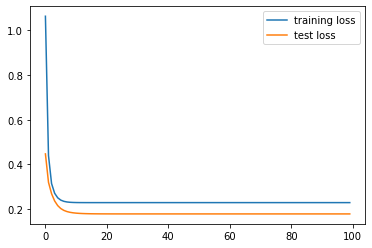

Minimal training error: 0.22883446096559232
Minimal test error: 0.1782717009407258


In [8]:
    # 1: Linear model

    input_dim = 2
    output_dim = 1
    nepochs = 100

    # Initializes the model
    linear = Linear(input_dim, output_dim)
    
    # Fix the learning rate
    learning_rate = 1e-2

    training_loss, test_loss = [], []
    for epoch in range(nepochs):
        
        train_err = []
        for n in range(nsamples):

            linear.compute_loss(xtrain[n], ytrain[n])
            linear.backward()
            linear.update(learning_rate)
            train_err.append(linear.loss)

        test_err = []
        for n in range(nsamples):

            linear.compute_loss(xtest[n], ytest[n])
            test_err.append(linear.loss)

        training_loss.append(np.array(train_err).mean())
        test_loss.append(np.array(test_err).mean())

    plt.plot(np.array(training_loss), label='training loss')
    plt.plot(np.array(test_loss), label='test loss')
    plt.legend()
    plt.show()

    print("Minimal training error: " + str(min(training_loss)))
    print("Minimal test error: " + str(min(test_loss)))

Now, let's do a little test :

In [9]:
linear.forward(np.array([0.5, 0.5]))
print("NN value for f(0.5, 0.5): ", linear.output[0])
print("Expected value          :  ", 0.5)

NN value for f(0.5, 0.5):  0.6783401536759943
Expected value          :   0.5


## 6. Neural network training

**Question 6.1.** Using the linear model as an inspiration, implement the training of the neural network on the data

**Question6.2.** What is the influence of the number of neurons in the hidden layer?

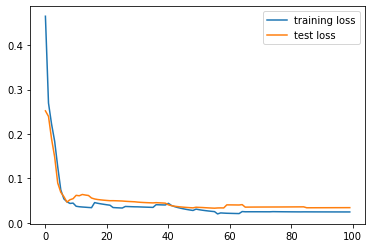

Minimal training error: 0.019915022495245852
Minimal test error: 0.03282757344403892


In [31]:
    # 2: NN

    input_dim = 2
    hidden_dim = 8
    output_dim = 1
    nepochs = 100

    # Initializes the model
    two_layers = TwoLayersNetwork(input_dim, hidden_dim, output_dim)
    
    # Fix the learning rate
    learning_rate = 1e-2

    training_loss, test_loss = [], []
    for epoch in range(nepochs):
        
        train_err = []
        for n in range(nsamples):

            two_layers.compute_loss(xtrain[n], ytrain[n])
            two_layers.backward()
            two_layers.update(learning_rate)
            train_err.append(two_layers.loss)

        test_err = []
        for n in range(nsamples):

            two_layers.compute_loss(xtest[n], ytest[n])
            test_err.append(two_layers.loss)

        training_loss.append(np.array(train_err).mean())
        test_loss.append(np.array(test_err).mean())

    plt.plot(np.array(training_loss), label='training loss')
    plt.plot(np.array(test_loss), label='test loss')
    plt.legend()
    plt.show()

    print("Minimal training error: " + str(min(training_loss)))
    print("Minimal test error: " + str(min(test_loss)))

In [32]:
two_layers.forward(np.array([0.5, 0.5]))
print("NN value for f(0.5, 0.5): ", two_layers.output[0])
print("Expected value          :  0.5")

NN value for f(0.5, 0.5):  0.5797442543725934
Expected value          :  0.5


Increasing the number of hidden neurons allows the model to learn better. However, the risk of overfitting increases when doing so. This is why a compromise must be made, and 8 neurons in the hidden layer seems to be a good option.

Furthermore, adding neurons in the hidden layer increases the calculation time. The compromise must also take this into account: increasing significantly the calculation time by adding neurons must meet a significant increase in the results.